In [2]:
import os
import time
import torch
import openai
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()
from sentence_transformers import SentenceTransformer
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer('intfloat/multilingual-e5-large').to(device)

/media/pixis/pixis/tausif_workspace/miniconda3/envs/any/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer('intfloat/multilingual-e5-small').to(device)

In [4]:
df_tagged_imgs = pd.read_csv("../tagged_dataset/final-tags.csv")
df_tagged_imgs = df_tagged_imgs.loc[:, ~df_tagged_imgs.columns.str.contains('^Unnamed')]
df_tagged_imgs.tail(2)

,image_name,image_path,tags,extended_tags,background_category
1308,280678d5-383f-450e-856e-08e2c11288e7.png,/media/pixis/pixis/Ravi_workspace/Entity-taggi...,"['circle', 'cotton candy', 'cube', 'green', 'h...","['minimalistic background', 'top view of stone...",MINIMALISTIC
1309,891a97af-592f-4837-bd62-693793401ff7.png,/media/pixis/pixis/Ravi_workspace/Entity-taggi...,"['crack', 'marble', 'stone', 'white']","['minimalistic background', 'kept on old shabb...",MINIMALISTIC


In [16]:
embeddings = model.encode("I hate coffee", normalize_embeddings=True)
print(embeddings[:10])
print(list(embeddings[:10]))
print(embeddings[:10])

[ 0.04336839 -0.00528187 -0.05279238 -0.10942847  0.12297848  0.0060142
  0.00608852  0.058235    0.04476909  0.01806945]
[0.04336839, -0.0052818675, -0.05279238, -0.109428465, 0.12297848, 0.006014198, 0.0060885195, 0.058234997, 0.044769086, 0.018069454]
[ 0.04336839 -0.00528187 -0.05279238 -0.10942847  0.12297848  0.0060142
  0.00608852  0.058235    0.04476909  0.01806945]


In [17]:
import ast
def get_tags_embeddings(tags_list):
    tags_list = ast.literal_eval(tags_list)
    tag_line = ', '.join(tags_list)
    embeddings = model.encode(tag_line, normalize_embeddings=True)
    embeddings = list(embeddings)
    return embeddings

start_time = time.time()
df_tagged_imgs["tag_embeddings"] = None
df_tagged_imgs["tag_embeddings"] = df_tagged_imgs["extended_tags"].progress_apply(get_tags_embeddings)
end_time = time.time()
execution_time = end_time - start_time

100%|██████████| 1310/1310 [00:05<00:00, 236.13it/s]


In [28]:
from PIL import Image
import numpy as np

def get_numpy_array(image_path):
    img = Image.open(image_path)
    return img

df_tagged_imgs["numpy_arr_img"] = df_tagged_imgs["image_path"].progress_apply(get_numpy_array)

100%|██████████| 1310/1310 [00:10<00:00, 126.76it/s]


In [29]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

def get_top_n_plots(top_image_arrays):
    images_per_row = 3
    total_images = len(top_image_arrays)
    rows = (total_images + images_per_row - 1) // images_per_row

    # Create a figure with the specified size
    fig, axes = plt.subplots(nrows=rows, ncols=images_per_row, figsize=(12, rows * 3))

    # Loop through the top_image_arrays and plot them
    for idx, img in enumerate(top_image_arrays):
        row = idx // images_per_row
        col = idx % images_per_row
        axes[row, col].imshow(img)
        axes[row, col].axis('off')

    # Hide any empty subplots
    for i in range(total_images, rows * images_per_row):
        row = i // images_per_row
        col = i % images_per_row
        axes[row, col].axis('off')

    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()


def get_top_n_similar_embeddings(new_embedding, tags_df, top_n=10):
    # Ensure the embeddings are in the correct format
    tag_embeddings = np.array(tags_df['tag_embeddings'].tolist())
    
    # Calculate the cosine similarity between the new embedding and the embeddings in the dataframe
    similarities = cosine_similarity([new_embedding], tag_embeddings)[0]
    
    top_indices = np.argsort(similarities)[-top_n:][::-1]
    
    top_similarities = similarities[top_indices]
    top_embeddings = tags_df.iloc[top_indices]
    
    # Get the image file paths of the top_n most similar embeddings
    top_image_arrays = top_embeddings['numpy_arr_img'].tolist()
    
    return top_image_arrays, top_similarities


In [30]:
def embed_query(input_query):
    input_query = ', '.join(input_query)
    embeddings = model.encode(input_query)
    return embeddings

In [9]:
temp = "[ 0.03845337 -0.01752222  0.0087373  -0.07322147  0.05666905 -0.0161007  0.03784212  0.01858897  0.06187897 -0.0104401   0.04120445  0.00596701  0.06615824 -0.00955554 -0.02014096  0.05894775  0.06758595 -0.06153618 -0.03555654 -0.0777443   0.02827294  0.00408157 -0.02347076  0.01284574  0.0657577   0.06675713 -0.02191298  0.01533112  0.02088296 -0.06807391 -0.08553325 -0.02869196  0.00633102 -0.04030583  0.04751755  0.00236643 -0.06285728 -0.07562113  0.00412356 -0.033477   -0.002813    0.00770476  0.04804204  0.12470887  0.04705267  0.04460897 -0.03698605  0.04707728 -0.07104229 -0.0758499  -0.06830055  0.03281515 -0.00654026  0.03821978  0.02822838 -0.04072765 -0.0248064  -0.0348235  -0.05716228  0.04076758  0.0762945  -0.03481773  0.00175246  0.04671362  0.07314541  0.09857725  0.04169474  0.01638919 -0.04161187 -0.0460563  -0.05395589  0.04765235 -0.0130797  -0.07431226  0.01247861  0.01122155  0.0177983  -0.08843657  0.0348504  -0.02714821 -0.05779564 -0.02873585 -0.07173621  0.06550417 -0.08023226  0.08276668  0.02817075 -0.08832587  0.07311859 -0.03335871  0.01189756  0.04441841 -0.0237125  -0.04310336 -0.09800581 -0.08136566 -0.08415153  0.04023121  0.06153813 -0.00551163  0.00606046 -0.01144622  0.04039035 -0.07516263 -0.02754674  0.00599732  0.07376726 -0.01602292  0.04086528 -0.04218545 -0.08030765  0.00927084  0.04935707  0.03810731 -0.00677254 -0.00787427 -0.02328571 -0.05373711  0.02429563 -0.04101527  0.08484332 -0.05842798 -0.03199522 -0.02605656 -0.10353148 -0.02966838  0.07713731  0.04210948 -0.00462942  0.00521589 -0.00553136  0.07114588  0.03783119  0.0595245   0.0498865   0.06622162 -0.03733643  0.04377603 -0.00980976 -0.00717301 -0.05970957  0.04103073 -0.03385125  0.0432267  0.06807372  0.02490643  0.02604032 -0.0201134   0.07396903  0.04422305  0.03467296 -0.01199968  0.08193858  0.00214524  0.04153768 -0.07844673 -0.05594694 -0.10116369  0.04358539  0.09225009 -0.06394913 -0.05609958 -0.08653838 -0.00214042 -0.07647741 -0.04906774  0.04267043  0.08953722 -0.02435811 -0.00714344 -0.12911464  0.05655181 -0.0296839   0.06621888 -0.04222358  0.02952674 -0.06558789  0.02556834  0.07467311  0.06243415 -0.02947072 -0.01983709 -0.06390125 -0.03823719 -0.09176613 -0.01014069 -0.09081794  0.01968751  0.00184015 -0.0361004   0.02218369  0.06095474 -0.05555214 -0.11301897 -0.03045715  0.02176761 -0.05666568 -0.00460156  0.06077963  0.04344493 -0.06731469 -0.02340208  0.03058726  0.01479491  0.03503063 -0.01918234 -0.07266046  0.08721105 -0.01309856  0.03230947  0.01717553 -0.07618117 -0.08062714  0.04081967 -0.04931917  0.01859729  0.01056177  0.06818669 -0.04397219  0.07510588  0.04602079 -0.03908112  0.03597049 -0.07046697 -0.00911483  0.03447112  0.0511651  -0.04999317 -0.04419198  0.06754622 -0.0513768  -0.02071579 -0.06837252 -0.08439617 -0.01982843 -0.05330648 -0.04196491  0.0480972   0.09320908 -0.07161912  0.02490675 -0.06937312  0.01138902 -0.06318194  0.07935914  0.0138842 -0.04084101  0.0315808  -0.03858147  0.03327478  0.01438231 -0.04153512 -0.06080906 -0.04205857 -0.03988773  0.03766309  0.07298442  0.07854001 -0.04615128  0.02964222  0.05787824 -0.03557433  0.07629642  0.05566797  0.03097132  0.00380348 -0.03588418 -0.02122484 -0.04773348 -0.03776208 -0.04613564  0.05918525  0.00835453 -0.00833501 -0.04250421 -0.03983053  0.03590998  0.0458237  -0.02584386 -0.02172317  0.02987258  0.02055869  0.07083742  0.08828413  0.03413322 -0.04261718 -0.01398847  0.05184189  0.00523268 -0.02423265 -0.03447901 -0.07244923  0.06994975 -0.02081058  0.04453408  0.04628183 -0.03340013  0.1117247  -0.0115062   0.05194663 -0.02900644 -0.04273189  0.02978732  0.06871241 -0.05398425  0.04260623 -0.03307346  0.01386749  0.01669994  0.04986152  0.06068318  0.0519852 -0.04613963 -0.00885075  0.09500192  0.05533924 -0.00547132  0.02362523 -0.05978558 -0.03837992 -0.02349871 -0.05441336 -0.01747886 -0.05211864  0.00078389  0.06093846 -0.0700638  -0.03205626  0.04309095 -0.0171514  0.0880181  -0.07372592 -0.07024962  0.01069165 -0.04577183 -0.00179909 -0.03994218  0.09745011 -0.05445588 -0.04457499  0.02158607  0.03884903 -0.03787886  0.04769172 -0.02719736 -0.07134006  0.05542581 -0.0575895 -0.02055979  0.07925609  0.07209836 -0.09411559  0.04388764  0.09639288 -0.01312531  0.02909594 -0.02372302 -0.07449418  0.09532171  0.04349841 -0.06444014 -0.01772974  0.05362481  0.04319514  0.0500836   0.02314507 -0.01022721 -0.00273525  0.06025153 -0.02584096  0.06121982  0.04143902 -0.01687763 -0.00446357 -0.01093696 -0.04499605 -0.02792801  0.0808419 -0.08074088 -0.06982688  0.02266311  0.08294335  0.02801169  0.01229652]"

a = ast.literal_eval(temp)

SyntaxError: invalid syntax. Perhaps you forgot a comma? (<unknown>, line 1)

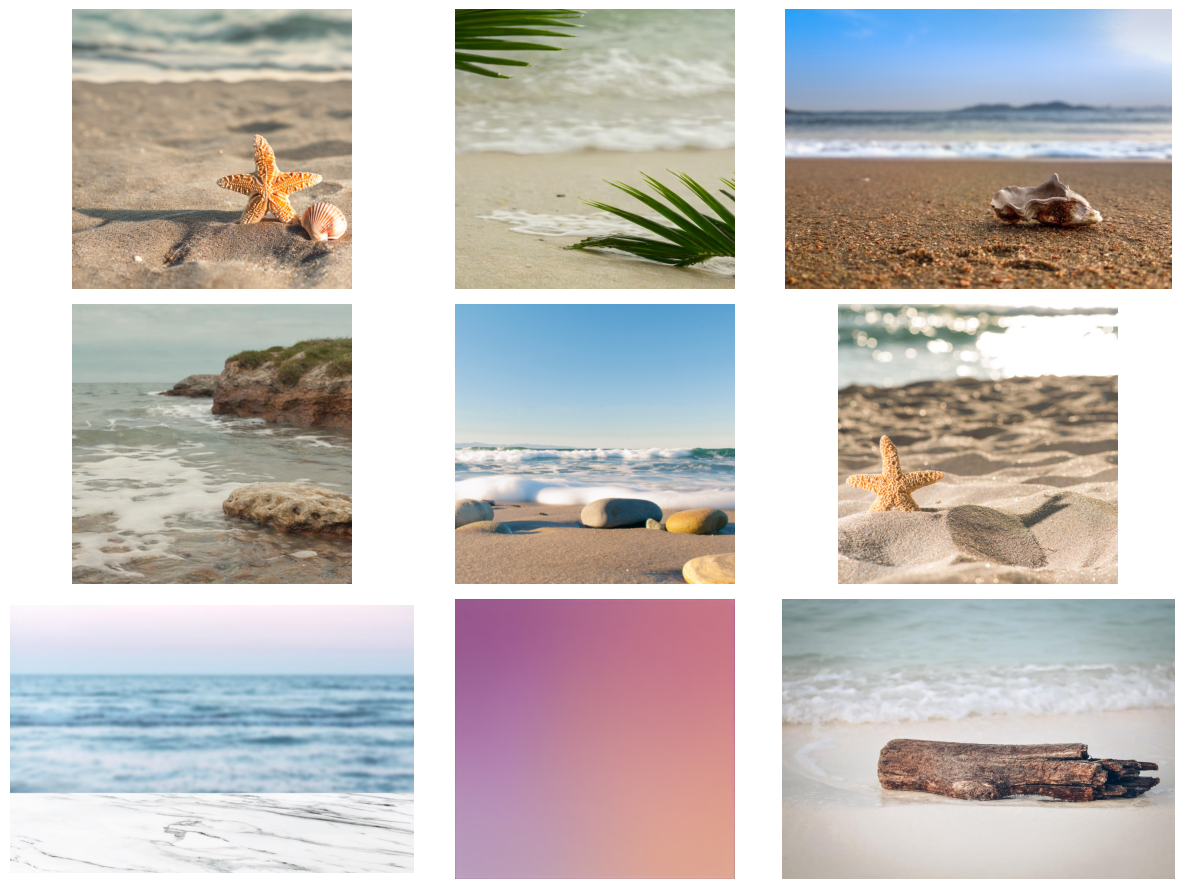

In [31]:
query = ["sea"]
curr_embbedding = embed_query(query)
top_image_arrays, top_similarities = get_top_n_similar_embeddings(curr_embbedding, df_tagged_imgs, top_n=9)
get_top_n_plots(top_image_arrays)

In [13]:
input_texts = ["blue sky, forest background"]
embeddings = model.encode(input_texts, normalize_embeddings=True)

In [16]:
embeddings.shape

(1, 384)

In [18]:
df_tagged_imgs.to_csv("./e5_embedded.csv")

In [6]:
!pip install sentence_transformers==2.2.2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 30.0 MB/s eta 0:00:00a 0:00:01
  Created wheel for sentence_transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125924 sha256=f69d443727231702cadb0bac71103a8d7698e750818186cc32c002bbbae84def
  Stored in directory: /home/pixis/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence_transformers
  Attempting uninstall: sentence_transformers
    Found existing installation: sentence-transformers 3.0.1
    Uninstalling sentence-transformers-3.0.1:
      Successfully uninstalled sentence-transformers-3.0.1
